In [ ]:
import os
import pandas as pd
import numpy as np

emo_data = pd.read_csv('/content/sentiment-analysis-data.csv')

np.max(emo_data['content'].apply(len))

538

In [ ]:
validation_split = 0.2
train_idxs = []
test_idxs = []

for name, idxs in emo_data.groupby('sentiment').groups.items():
  idxs = idxs.to_list()
  np.random.shuffle(idxs)
  idx_split = int(validation_split * len(idxs))
  train_idxs += idxs[idx_split:]
  test_idxs += idxs[:idx_split]

np.random.shuffle(train_idxs)
np.random.shuffle(test_idxs)
train_samples = emo_data.iloc[train_idxs]
test_samples = emo_data.iloc[test_idxs]

In [ ]:
train_samples.groupby('sentiment').count()

,content
sentiment,
anger,8902
disgust,811
fear,2619
joy,23962
sadness,11892
surprise,7650


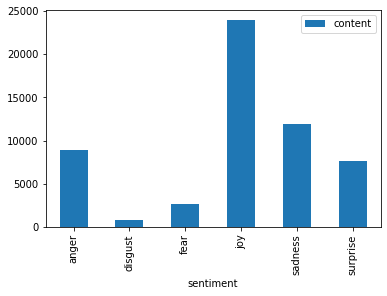

In [ ]:
train_samples.groupby('sentiment').count().plot(kind='bar')

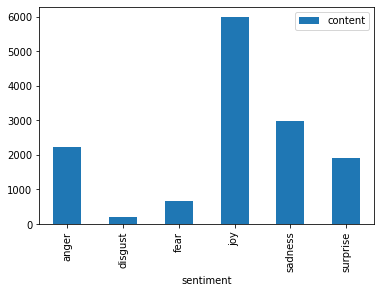

In [ ]:
#split the data evenly among the trainng and test sets although the data is highly severely imbalanced
test_samples.groupby('sentiment').count().plot(kind='bar')

In [ ]:
emotion_dict = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'sadness':4, 'surprise':5}

In [ ]:
train_samples['sentiment'] = train_samples['sentiment'].apply(lambda x: emotion_dict[x])

test_samples['sentiment'] = test_samples['sentiment'].apply(lambda x: emotion_dict[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_samples, train_labels = train_samples.values[:,1], train_samples.values[:,0]

test_samples, test_labels = test_samples.values[:,1], test_samples.values[:,0]

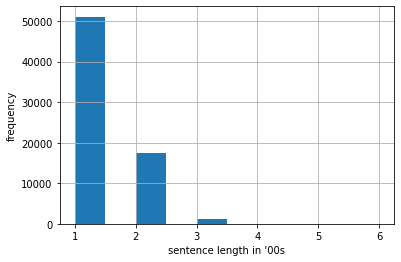

In [ ]:
import matplotlib.pyplot as plt
sentence_lengths = (emo_data['content'].apply(len) // 100) + 1

sentence_lengths.hist()
plt.xlabel("sentence length in '00s");
plt.ylabel('frequency');

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
train_labels = keras.utils.to_categorical(train_labels, 6)
test_labels = keras.utils.to_categorical(test_labels, 6)

In [ ]:
#from the figure above keeping a max output_sequence_length of 200 is more than sufficient
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)

text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
emotion_dict

{'anger': 0, 'disgust': 1, 'fear': 2, 'joy': 3, 'sadness': 4, 'surprise': 5}

In [ ]:
reverse_emotion_dict = {}

In [ ]:
for key, val in emotion_dict.items():
  reverse_emotion_dict[val] = key

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-07-04 14:00:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-04 14:00:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-04 14:00:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import os

embeddings_index = {}

with open('/content/glove.6B.100d.txt') as f:
  for line in f:
    word, coeffs = line.split(maxsplit=1)
    coeffs = np.fromstring(coeffs, 'f', sep=' ')
    embeddings_index[word] = coeffs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
vocab = vectorizer.get_vocabulary()

word_index = dict(zip(vocab, range(len(vocab))))

In [ ]:
num_tokens = len(vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    misses += 1

print('Converted %s words and %s misses' % (hits, misses))

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(num_tokens,
                            embedding_dim,
                            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                            trainable=False)

In [ ]:
input_sequences = keras.Input(shape=(None,), dtype='int32')
embedded_sequences = embedding_layer(input_sequences)
x = keras.layers.SpatialDropout1D(0.3)(embedded_sequences)
x = keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True))(x)
x = keras.layers.Conv1D(64, 3, activation='relu')(x)
x1 = keras.layers.GlobalMaxPooling1D()(x)
x2 = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Concatenate(axis=1)([x1, x2])
preds = keras.layers.Dense(6, activation='softmax')(x)

model = keras.Model(inputs=input_sequences, outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 100)    1000200     ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, None, 100)   0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, None, 512)    731136      ['spatial_dropout1d[0][0]']  

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy',  metrics=['acc'])

In [ ]:
x_train = vectorizer(train_samples)
x_test = vectorizer(test_samples)

In [ ]:
model_history = model.fit(x_train, train_labels, batch_size=128, epochs=15, validation_data=(x_test, test_labels))

Epoch 1/15
394/394 [==============================] - 31s 71ms/step - loss: 1.1602 - acc: 0.5547 - val_loss: 0.9228 - val_acc: 0.6526
Epoch 2/15
394/394 [==============================] - 27s 68ms/step - loss: 0.9093 - acc: 0.6540 - val_loss: 0.7816 - val_acc: 0.7109
Epoch 3/15
394/394 [==============================] - 26s 67ms/step - loss: 0.8121 - acc: 0.6944 - val_loss: 0.7205 - val_acc: 0.7290
Epoch 4/15
394/394 [==============================] - 27s 67ms/step - loss: 0.7504 - acc: 0.7189 - val_loss: 0.6818 - val_acc: 0.7486
Epoch 5/15
394/394 [==============================] - 27s 68ms/step - loss: 0.7033 - acc: 0.7366 - val_loss: 0.6653 - val_acc: 0.7527
Epoch 6/15
394/394 [==============================] - 27s 68ms/step - loss: 0.6677 - acc: 0.7514 - val_loss: 0.6425 - val_acc: 0.7614
Epoch 7/15
394/394 [==============================] - 27s 68ms/step - loss: 0.6377 - acc: 0.7620 - val_loss: 0.6389 - val_acc: 0.7667
Epoch 8/15
394/394 [==============================] - 27s 68ms

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(model_history, metric):
  epochs = len(model_history.history[metric])
  plt.plot(range(epochs),model_history.history[metric])
  plt.plot(range(epochs),model_history.history['val_'+metric])
  plt.xlabel('epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.figure()

plot_graph(model_history, 'acc')
plot_graph(model_history, 'loss')

In [ ]:
#There's an obvious bias in my algorithm towards not, perhaps in a future development this will be attended to
reverse_emotion_dict[np.argmax(model.predict(vectorizer(["I feel happy"])))]

'joy'

In [ ]:
reverse_emotion_dict[np.argmax(model.predict(test_vec(["I do not feel pain below the belt"])))]


'sadness'

In [ ]:
#model.save('/content/model/my_model')

INFO:tensorflow:Assets written to: /model/my_model/assets


INFO:tensorflow:Assets written to: /model/my_model/assets


In [ ]:
model.save('/content/model/my_model.h5')

In [ ]:
old_model = keras.models.load_model('/content/model/my_model.h5')

In [ ]:
import pickle as pkl

In [ ]:
with open('/content/vectorizer_file/vectorizer.pkl','wb') as f:
  pkl.dump({'config':vectorizer.get_config(), 'weights':vectorizer.get_weights()}, f)

In [ ]:
with open('/content/vectorizer_file/vectorizer.pkl','rb') as f:
  test_dict = pkl.load(f)


In [ ]:
test_vec = TextVectorization.from_config(test_dict['config'])

test_vec.set_weights(test_dict['weights'])

In [ ]:
prediction = model.predict(vectorizer(['I am not feeling bad']))